### **1. Set up libraries and load data**

#### 1.1 import libraries

In [1]:
import seaborn as sns              
import matplotlib.pyplot as plt    
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OneHotEncoder       
from sklearn.compose import ColumnTransformer        
from sklearn.pipeline import Pipeline                 
from sklearn.tree import DecisionTreeClassifier, plot_tree  
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
from pathlib import Path     
from IPython.display import Image, display                        

#### 1.2 Load the dataset

In [2]:
penguins = sns.load_dataset("penguins")    
penguins.dropna(inplace=True) 
display(penguins)              

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


### **2. Preparing the datasets**

#### 2.1 Identify features & labels

In [3]:
features = ['island','bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g','sex']
X = penguins[features]
y = penguins['species'] # Adelie, Chinstrap, Gentoo

#### 2.2 One-hot encoding for the variable sex and island (categorical)

In [4]:
categorical = ['sex', 'island']
numeric     = list(set(features) - set(categorical))
preprocess  = ColumnTransformer(
      [("cat", OneHotEncoder(), categorical),
       ("num", "passthrough", numeric)]
)

#### 2.3 Create 4 train/test pairs with ratios 40/60, 60/40, 80/20, 90/10, then shuffle and stratify

In [5]:
splits = {}
for train_size in [0.4, 0.6, 0.8, 0.9]:
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=42, shuffle=True)
    key = f"{round(train_size*100)}/{round((1-train_size)*100)}"
    splits[key] = (X_tr, X_te, y_tr, y_te)

#### 2.4 Display class distribution

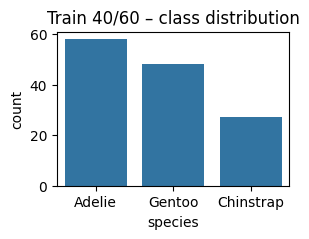

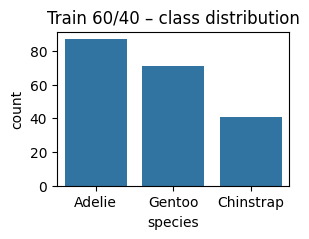

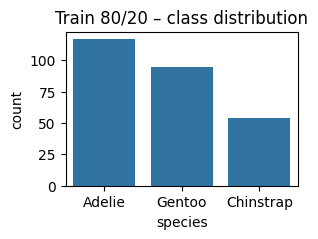

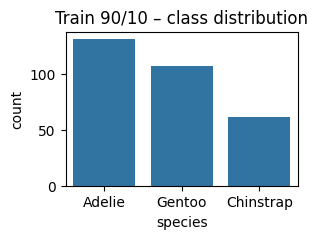

In [6]:
for name,(X_tr, X_te, y_tr, y_te) in splits.items():
    plt.figure(figsize=(3,2))
    sns.countplot(x=y_tr, order=y.value_counts().index)
    plt.title(f"Train {name} – class distribution")
    plt.show()

### **3. Training & Visualizing Decision Tree (Building the classifiers)**


--- Train/Test Split: 40-60 ---


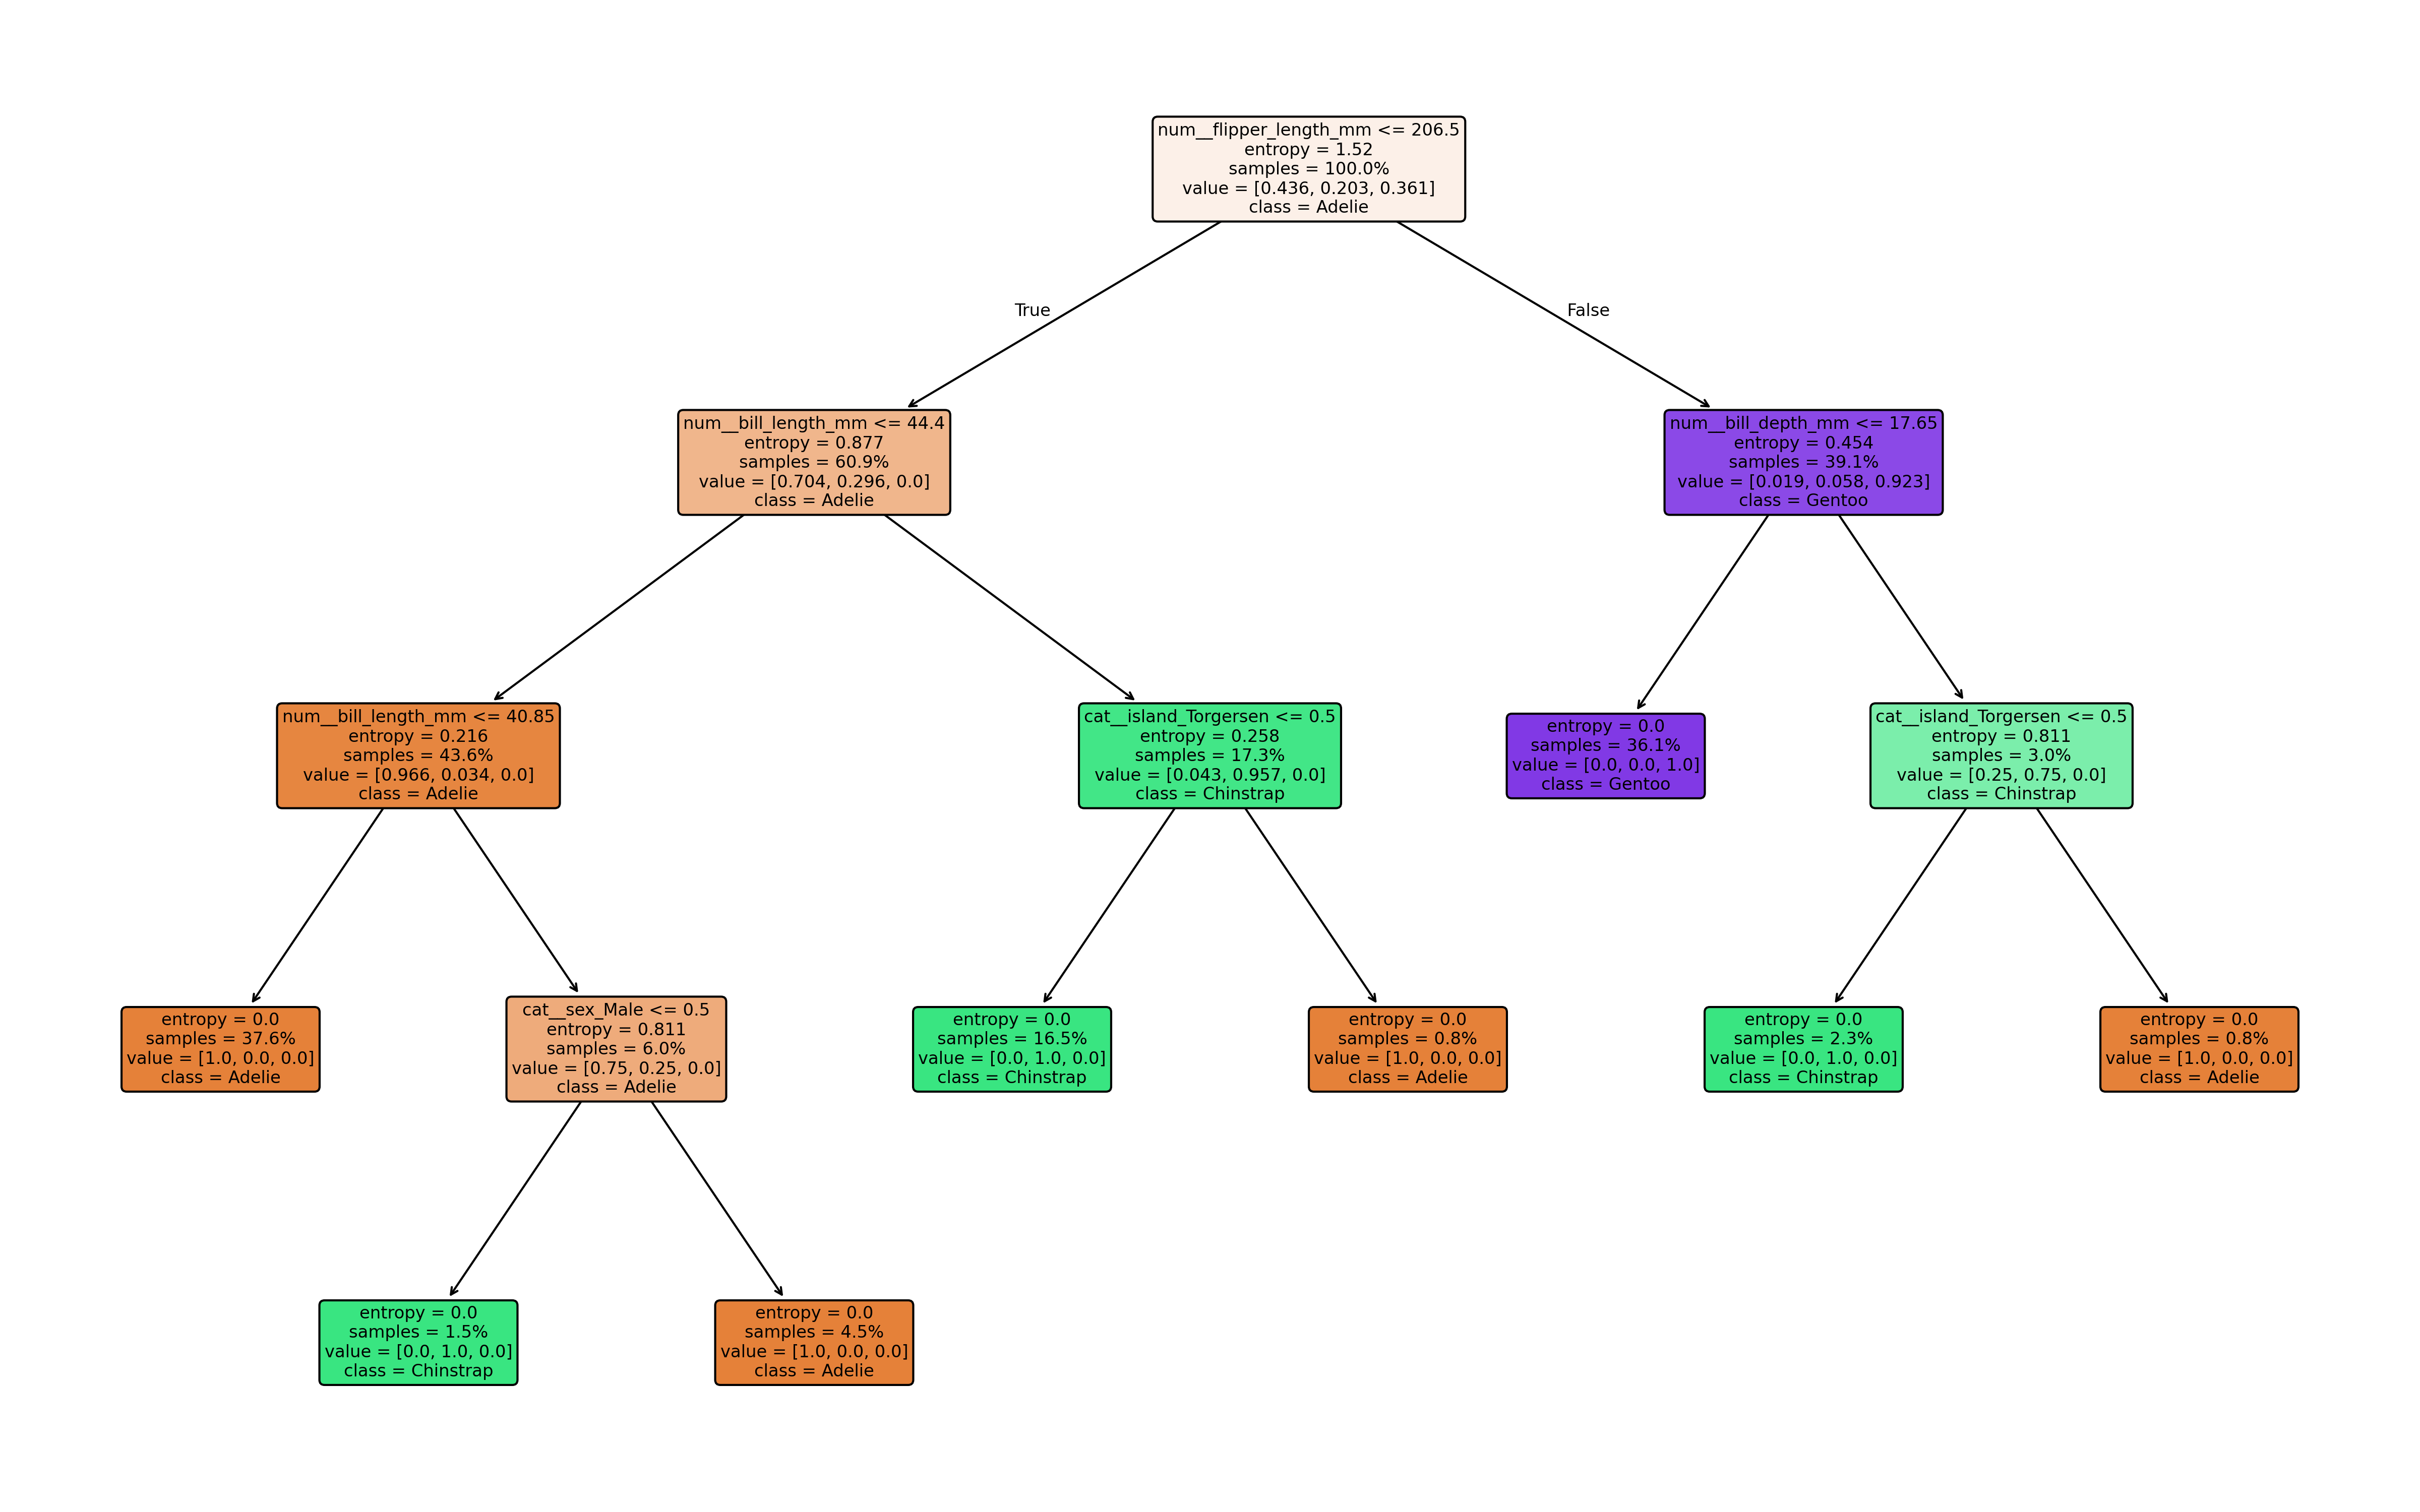


--- Train/Test Split: 60-40 ---


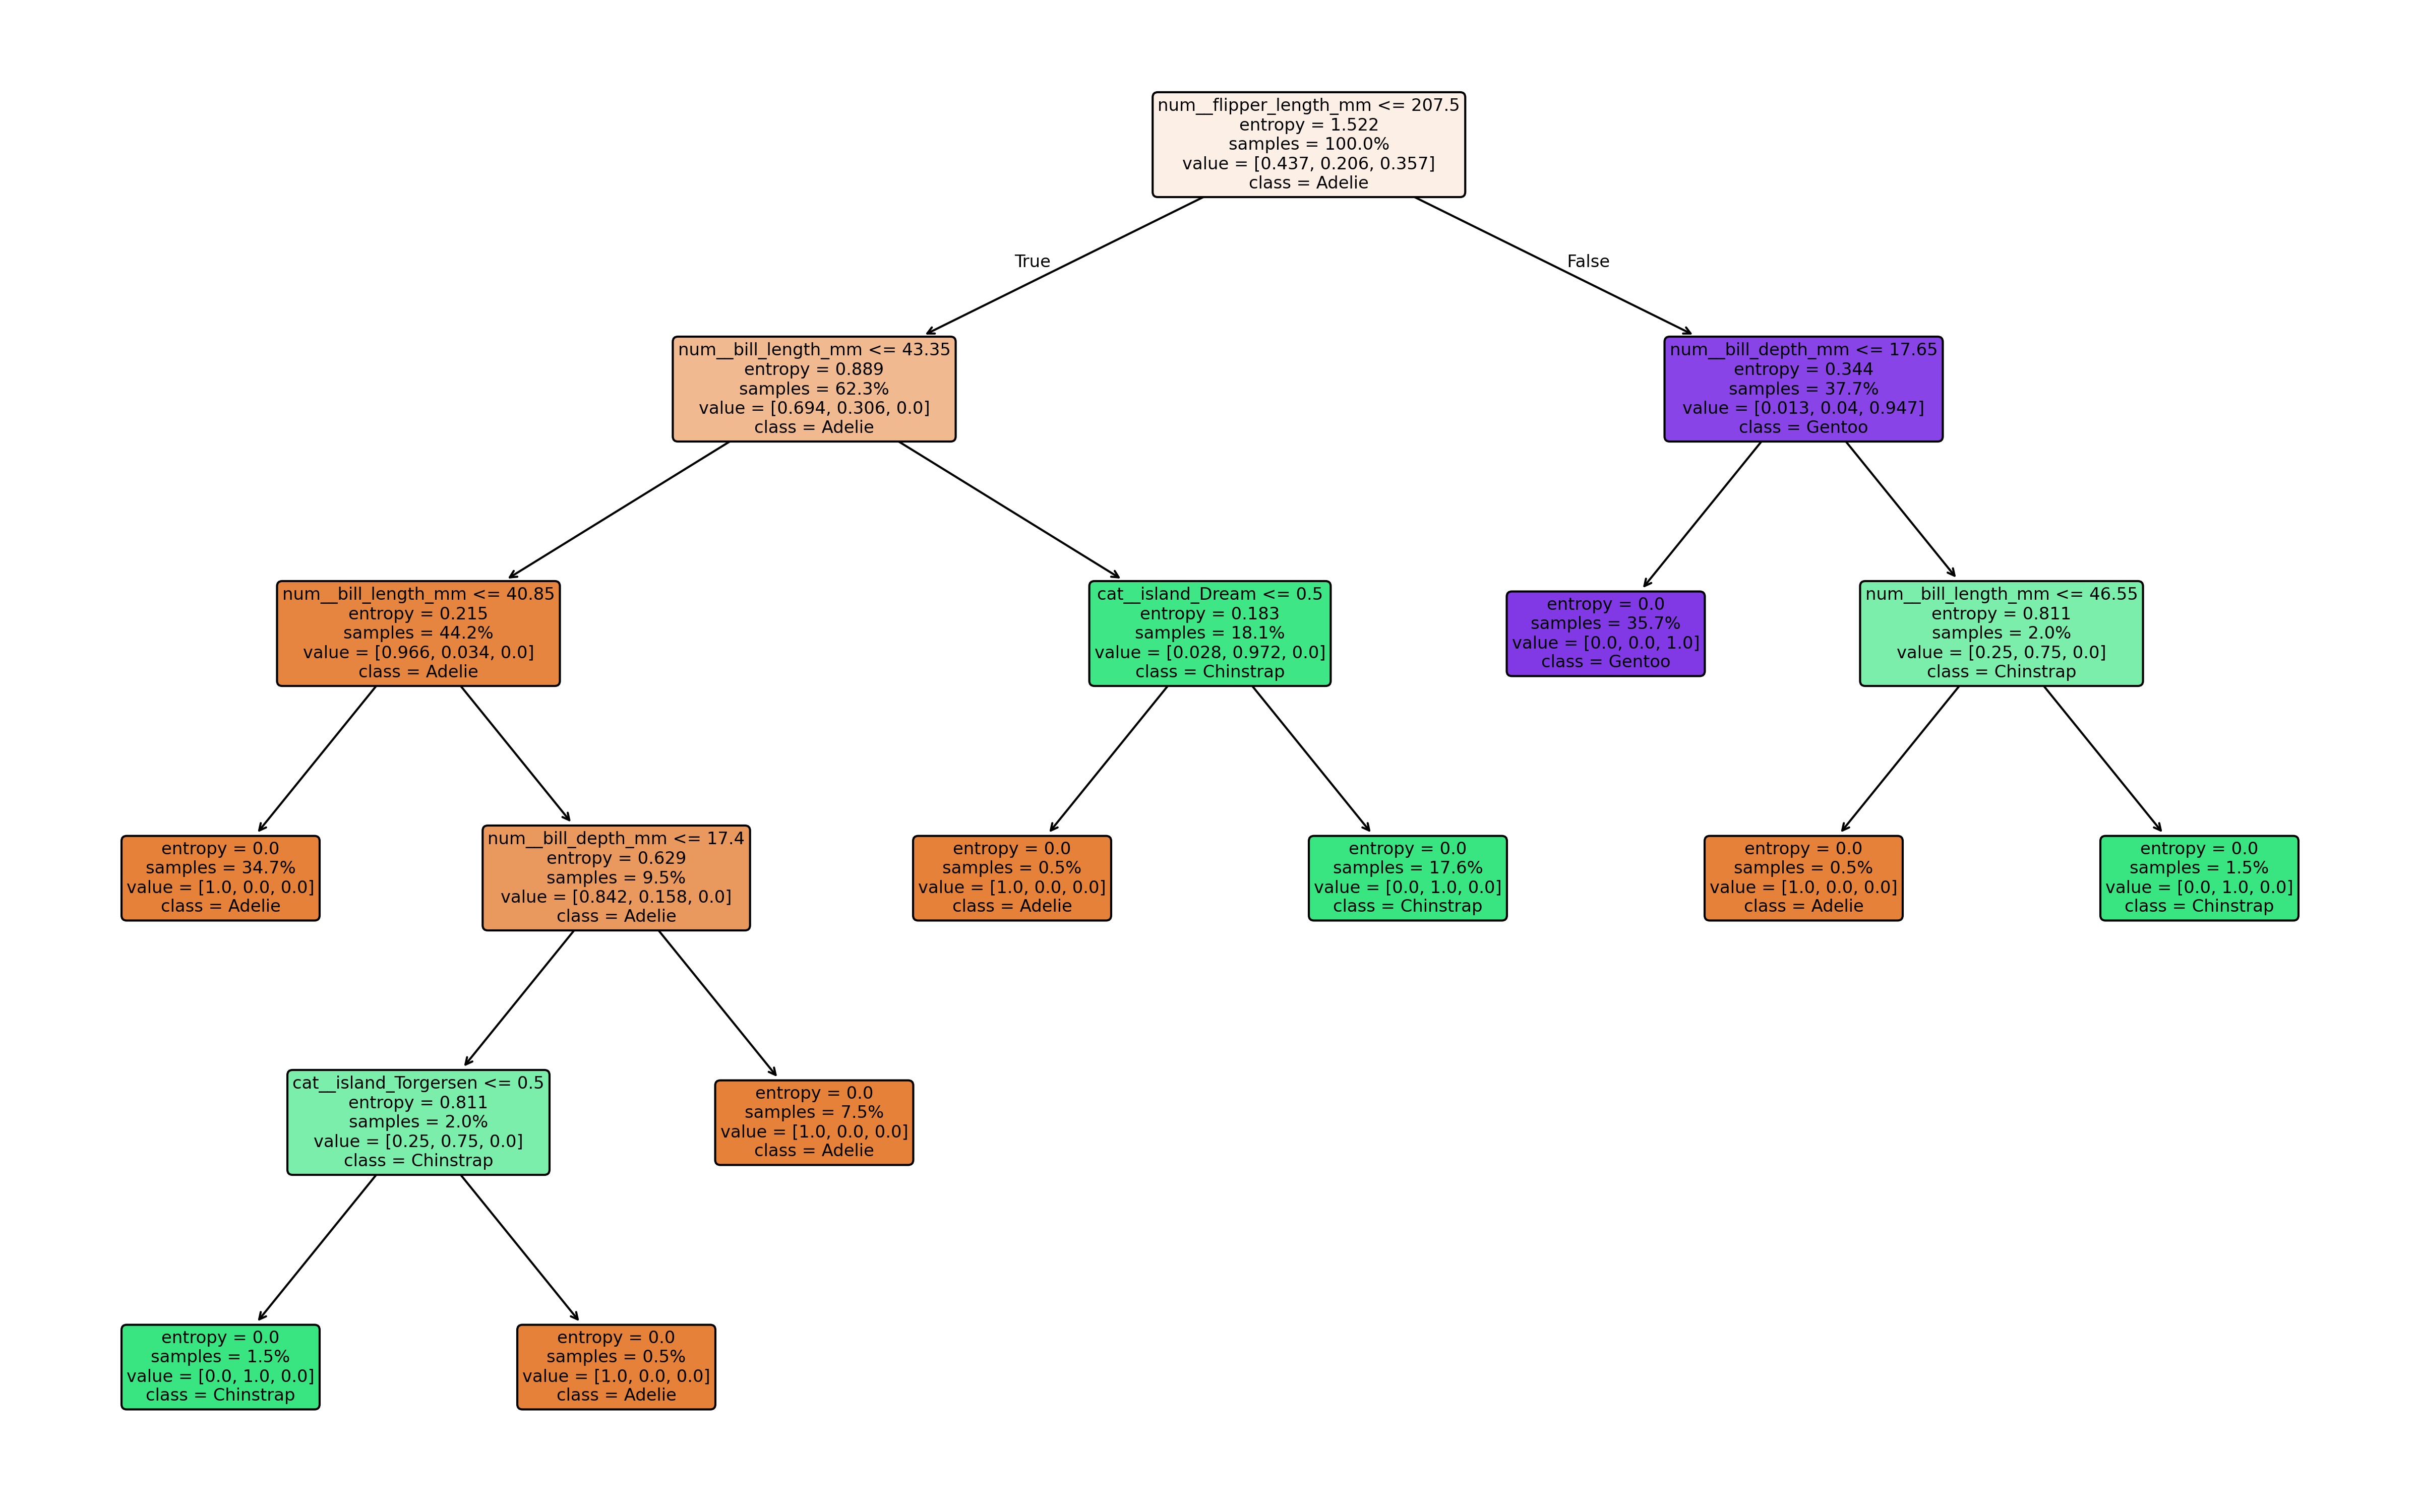


--- Train/Test Split: 80-20 ---


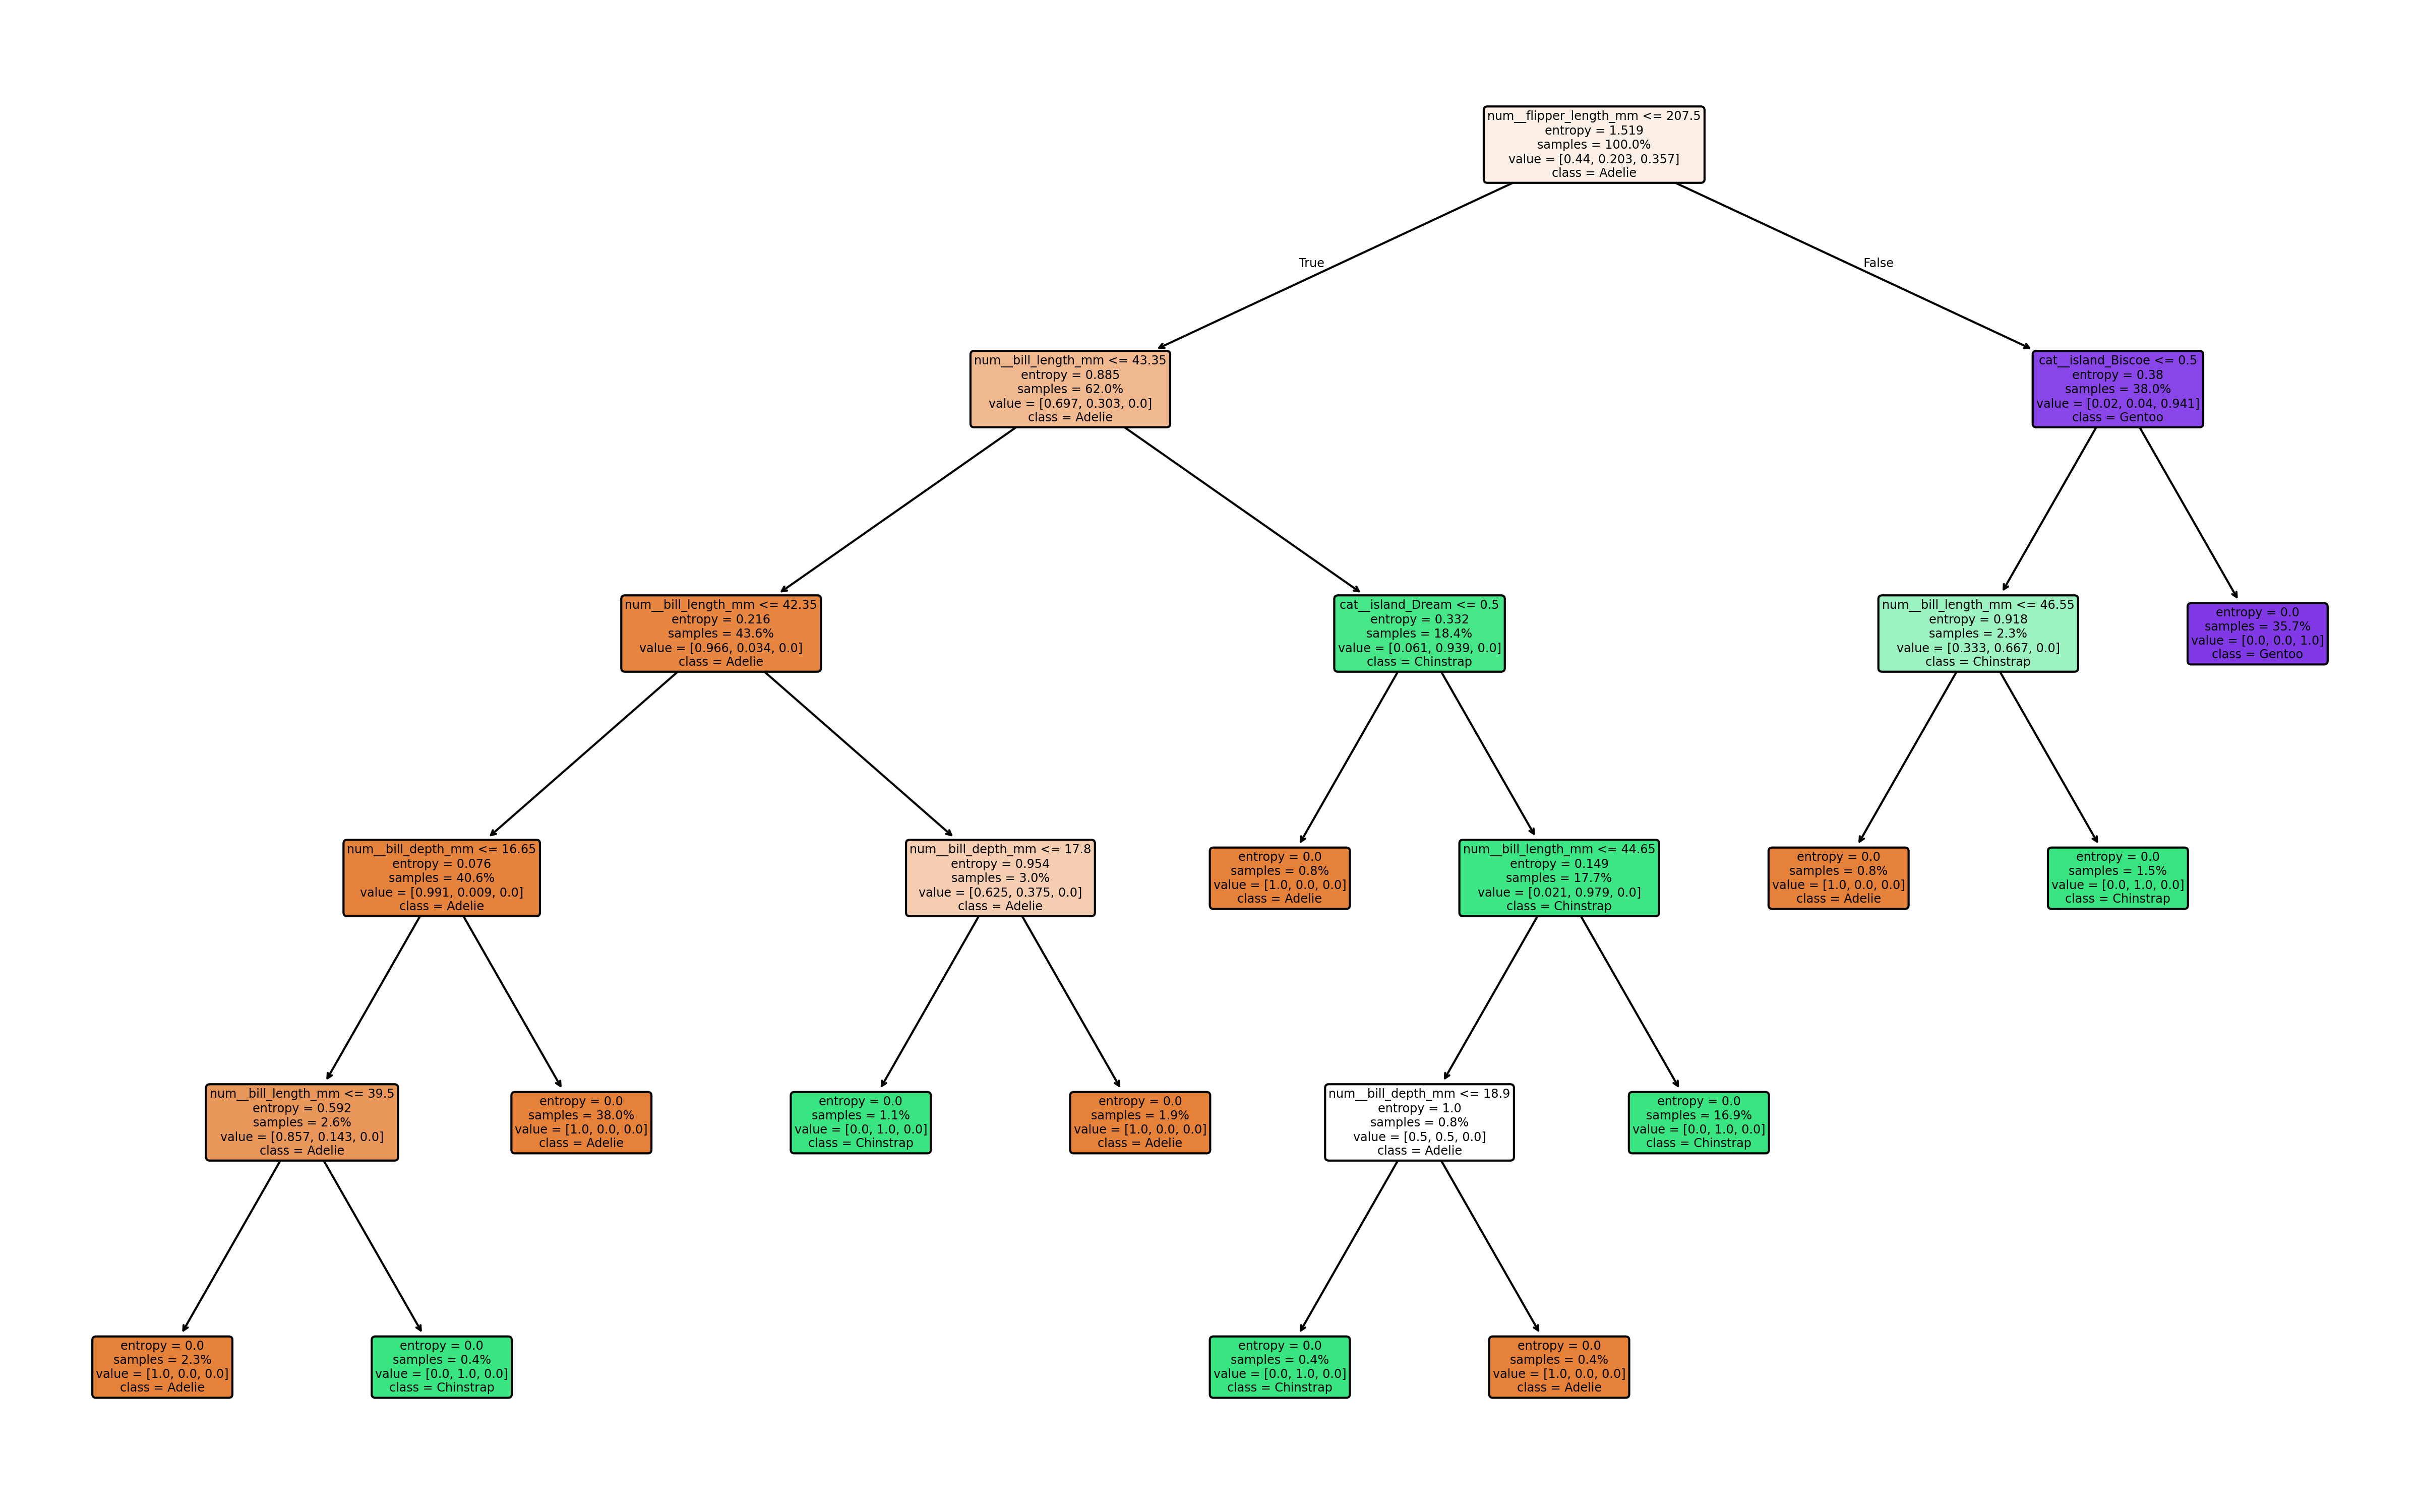


--- Train/Test Split: 90-10 ---


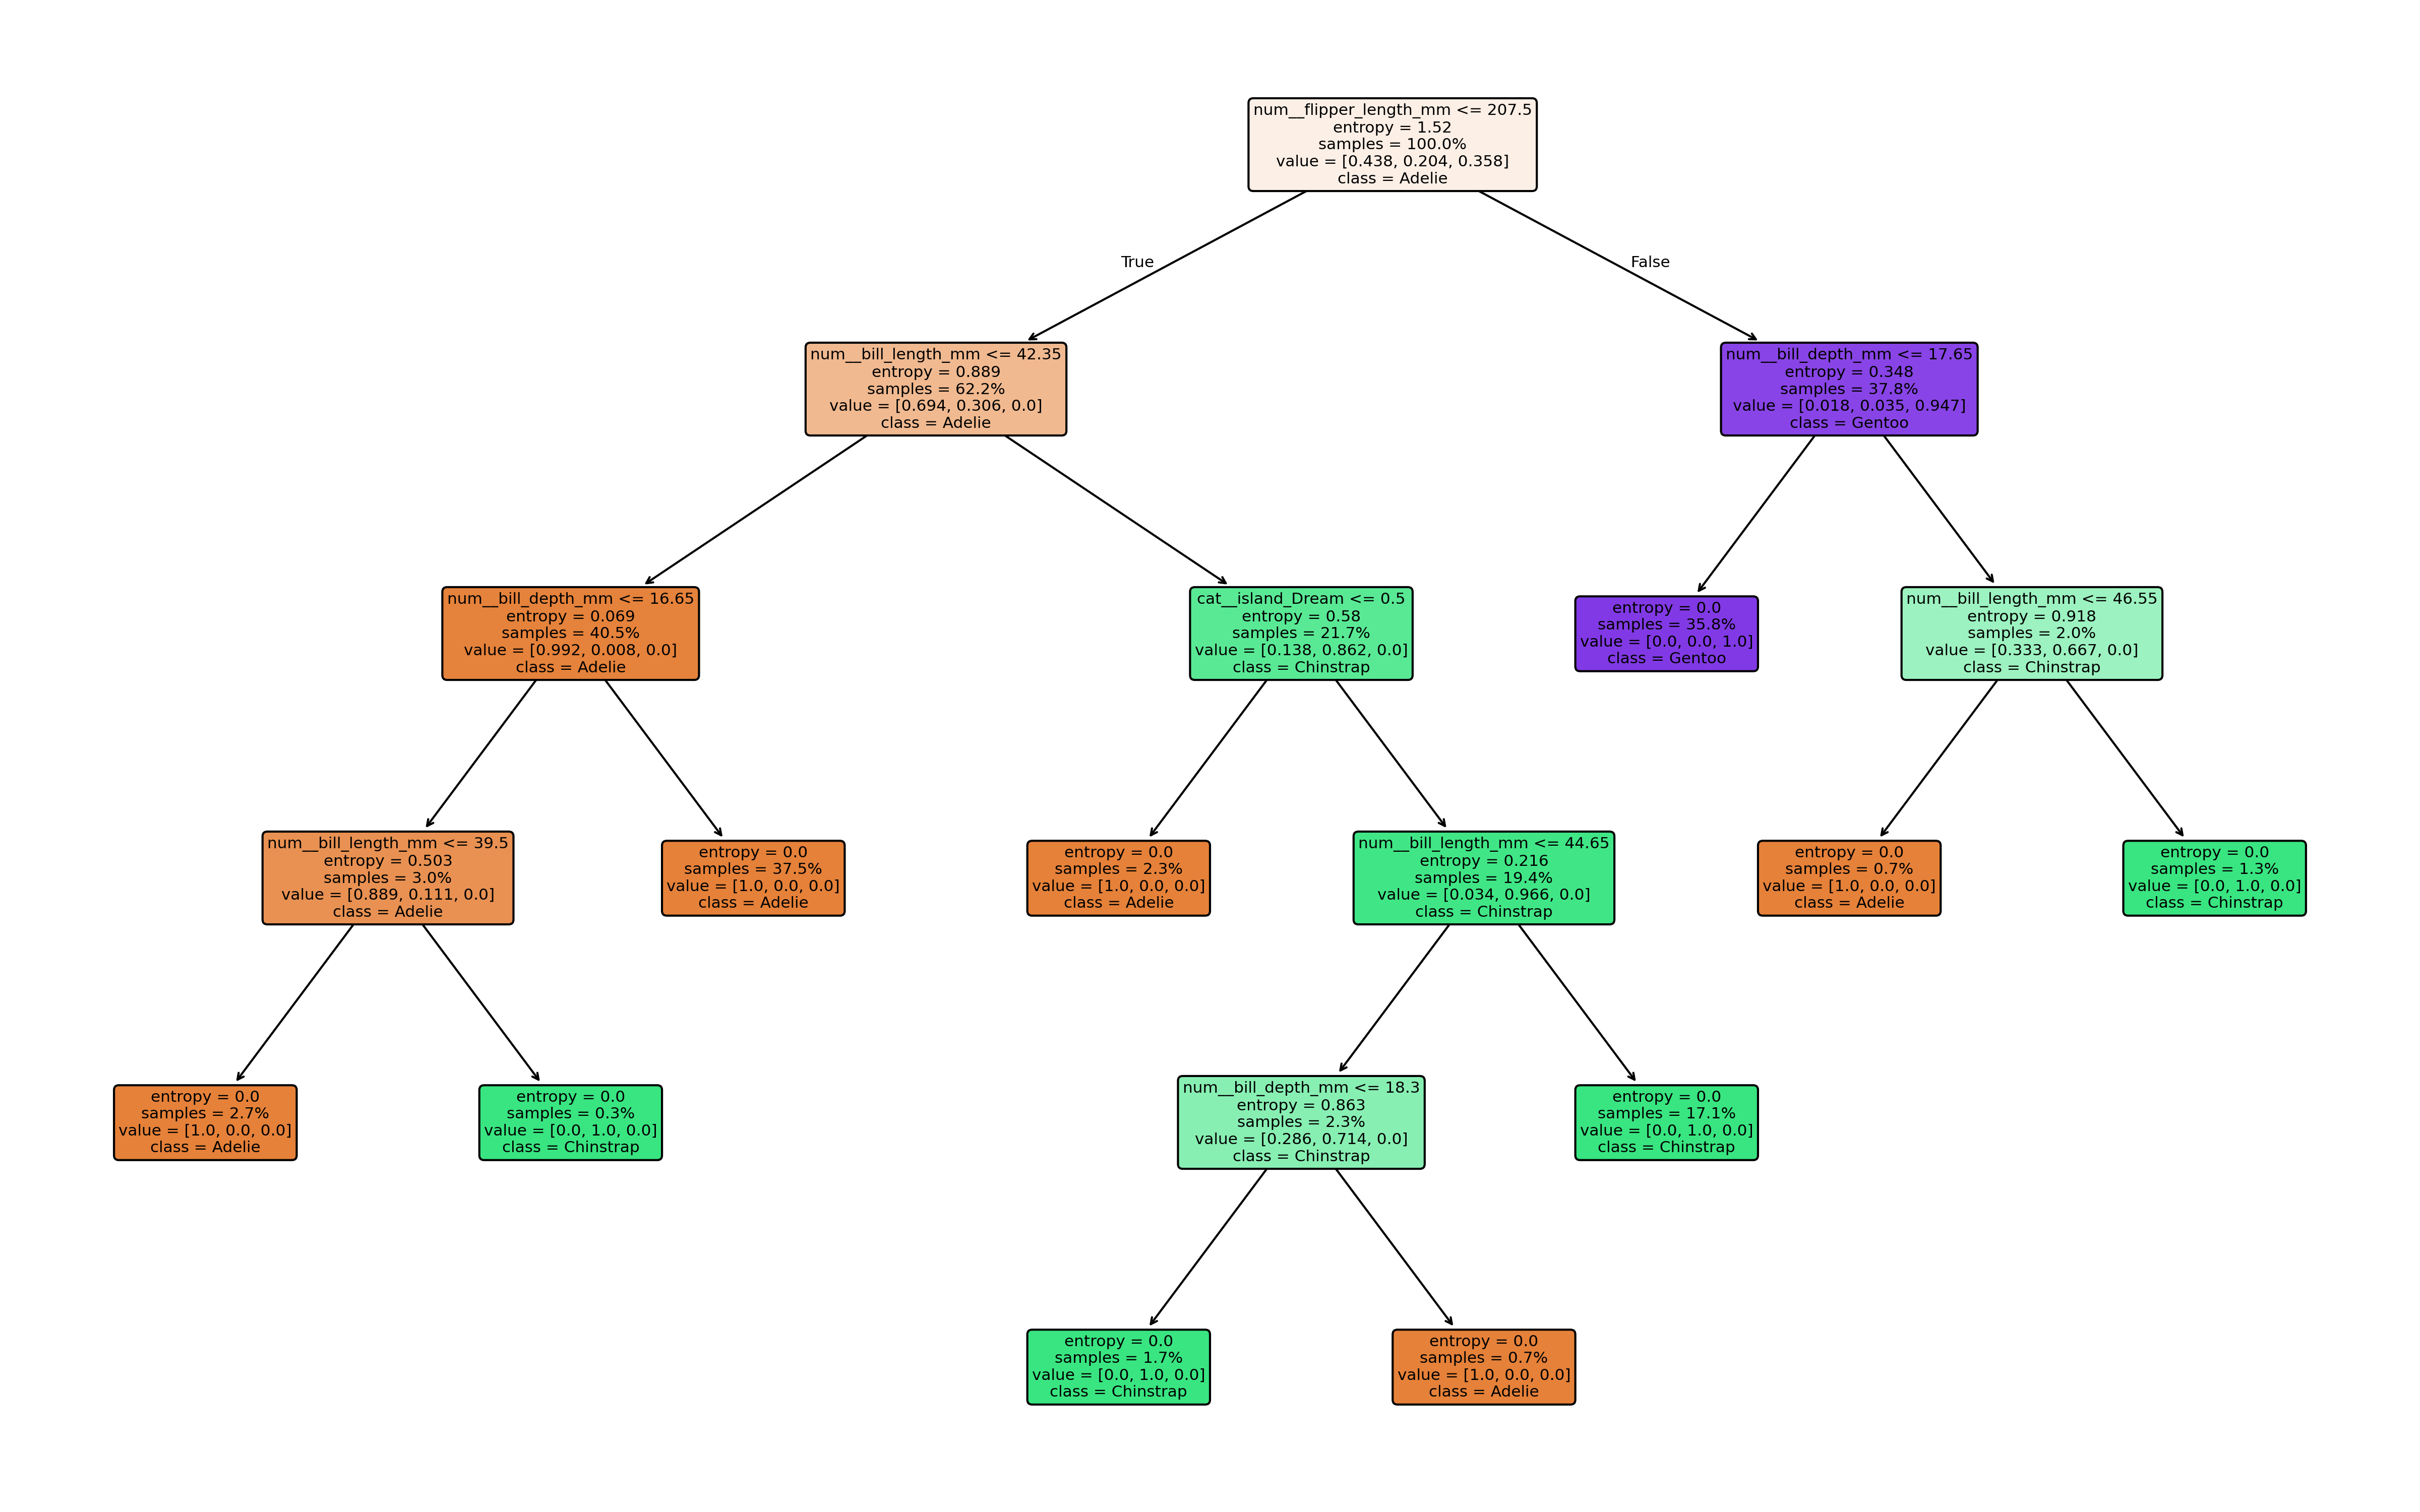

In [7]:
Path("figures").mkdir(exist_ok=True)    # create root folder

for name, (X_tr, X_te, y_tr, y_te) in splits.items():
    clf = Pipeline([
        ("prep", preprocess),
        ("dt",  DecisionTreeClassifier(criterion="entropy", random_state=42))
    ]).fit(X_tr, y_tr)

    plt.figure(figsize=(16, 10))
    plot_tree(
        clf.named_steps["dt"],
        feature_names=clf.named_steps["prep"].get_feature_names_out(),
        class_names=clf.named_steps["dt"].classes_,
        filled=True, rounded=True, proportion=True
    )
    plt.tight_layout()

    # --- save image ---
    safe_name = name.replace("/", "-")              # avoid path error
    plt.savefig(f"figures/tree_penguins_{safe_name}.png", dpi=300)
    print(f"\n--- Train/Test Split: {safe_name} ---")
    display(Image(f"figures/tree_penguins_{safe_name}.png"))
    plt.close()



### **4. Model Evaluation (Evaluating the classifiers)**


### 40/60 split ###
              precision    recall  f1-score   support

      Adelie      1.000     0.943     0.971        88
   Chinstrap      0.872     1.000     0.932        41
      Gentoo      1.000     0.986     0.993        71

    accuracy                          0.970       200
   macro avg      0.957     0.976     0.965       200
weighted avg      0.974     0.970     0.971       200



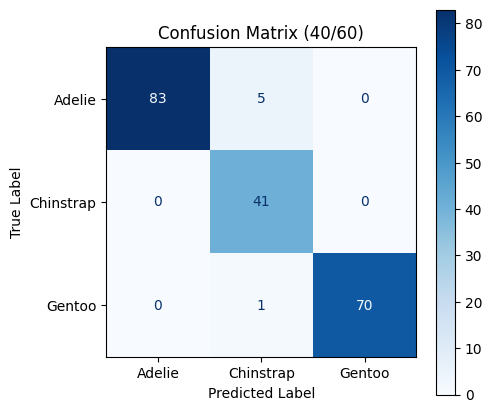


### 60/40 split ###
              precision    recall  f1-score   support

      Adelie      0.967     0.983     0.975        59
   Chinstrap      0.964     1.000     0.982        27
      Gentoo      1.000     0.958     0.979        48

    accuracy                          0.978       134
   macro avg      0.977     0.980     0.978       134
weighted avg      0.978     0.978     0.978       134



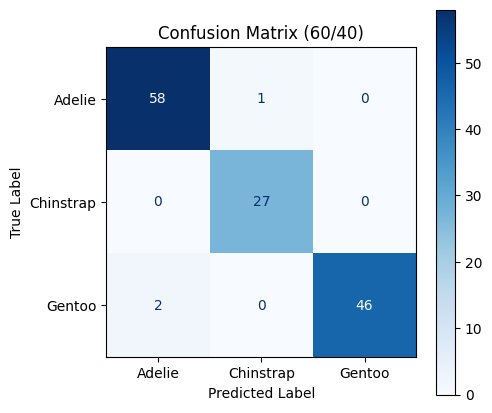


### 80/20 split ###
              precision    recall  f1-score   support

      Adelie      0.933     0.966     0.949        29
   Chinstrap      0.933     1.000     0.966        14
      Gentoo      1.000     0.917     0.957        24

    accuracy                          0.955        67
   macro avg      0.956     0.961     0.957        67
weighted avg      0.957     0.955     0.955        67



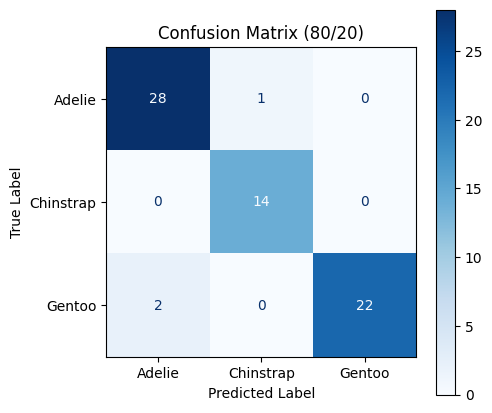


### 90/10 split ###
              precision    recall  f1-score   support

      Adelie      0.882     1.000     0.938        15
   Chinstrap      1.000     1.000     1.000         7
      Gentoo      1.000     0.833     0.909        12

    accuracy                          0.941        34
   macro avg      0.961     0.944     0.949        34
weighted avg      0.948     0.941     0.940        34



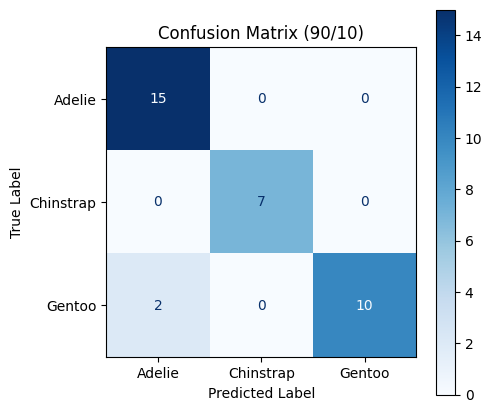

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

# Train and store models for each split
models = {}
for name, (X_tr, X_te, y_tr, y_te) in splits.items():
    clf = Pipeline([
        ("prep", preprocess),
        ("dt", DecisionTreeClassifier(criterion="entropy", random_state=42))
    ]).fit(X_tr, y_tr)
    models[name] = (clf, X_te, y_te)

import matplotlib.pyplot as plt

for name, (clf, X_te, y_te) in models.items():
    # 1) In báo cáo
    y_pred = clf.predict(X_te)
    print(f"\n### {name} split ###")
    print(classification_report(y_te, y_pred, digits=3))

    # 2) Tính ma trận nhầm lẫn (số)
    cm = confusion_matrix(y_te, y_pred)

    # 3) Vẽ heat-map confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=clf.classes_)
    fig, ax = plt.subplots(figsize=(5,5))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    ax.set_title(f"Confusion Matrix ({name})")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.show()


### **5. Effect of Tree Depth (Depth vs Accuracy – 80/20)**

Saved tree images to the fig_depth/ folder


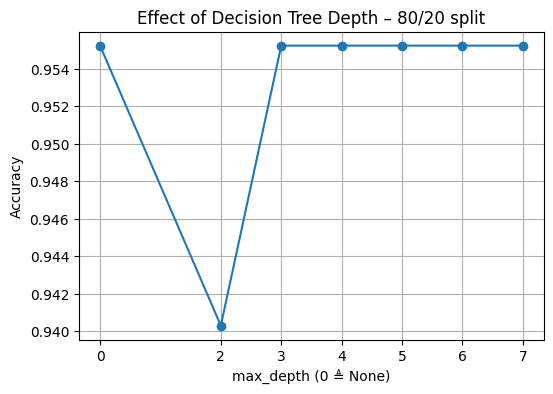

In [9]:
# ❶ Get the correct 80/20 split
X_tr, X_te, y_tr, y_te = splits["80/20"]

# ❷ Try different max_depth values
depths = [None, 2, 3, 4, 5, 6, 7]
acc = []

# ❸ Create a folder to save images
Path("fig_depth").mkdir(exist_ok=True)

for d in depths:
    clf = Pipeline([
        ("prep", preprocess),
        ("dt",  DecisionTreeClassifier(
                    criterion="entropy",
                    max_depth=d,
                    random_state=42))
    ]).fit(X_tr, y_tr)

    # Accuracy
    y_pred = clf.predict(X_te)
    acc.append(accuracy_score(y_te, y_pred))

    # Plot the tree using matplotlib
    plt.figure(figsize=(16, 10))
    plot_tree(
        clf.named_steps["dt"],
        feature_names=clf.named_steps["prep"].get_feature_names_out(),
        class_names=clf.named_steps["dt"].classes_,
        filled=True, rounded=True, proportion=True
    )
    plt.tight_layout()

    depth_tag = d if d is not None else "None"
    plt.savefig(f"fig_depth/tree_depth_{depth_tag}.png", dpi=300)
    plt.close()

print("Saved tree images to the fig_depth/ folder")

# ❹ Plot depth vs Accuracy chart
plt.figure(figsize=(6,4))
plt.plot([0 if d is None else d for d in depths], acc, marker="o")
plt.xticks([0]+depths[1:])
plt.xlabel("max_depth (0 ≜ None)")
plt.ylabel("Accuracy")
plt.title("Effect of Decision Tree Depth – 80/20 split")
plt.grid(True)
plt.show()